## Spark - Key Features

- Easy to use
  - Comes with an expressive API - 80+ operators. 
  - Different levels of abstraction - RDDs, DataFrames, SparkSQL etc.
  - API in - Java, Scala, Python, R
  - Cluster Managers - Yarn, Mezos, Spark
- Fast
  - In-memory cluster computing capabilities
  - Application can cache the data in memory - subsequent operations are performed on the cached data.
  - Advanced job execution engine 
    - job converted to DAG of stages.
    - job can contain several stages
    - stage execution - optimized to minimize data movement
- General Purpose
  - batch processing
  - interactive analysis
  - stream processing
  - machine learning
  - graph computing
- Scallable
  - just add new nodes to the cluster
- Fault tolerant
  - 100+ node cluster high chance of failure
  - Automatic node failure handling
  - Failed tasks are automatically re-executed on different node

## High Level Architecture

Terms:
- Shuffle
  - Redistributes data between the nodes.
  - Expensive
  - Not random - groups data on criteria into bucket
  - each bucket - partition
- Job
  - An execution of a data processing algorithm.
- Stage
  - A collection of tasks in shuffle boundaries
  - Tasks without shuffle - stage
  - Tasks that require shuffle, start a new stage
  - Stage depend on each other.
  

Five key entities:
- Driver Program
  - an application, uses Spark library - provides code, executed on worker nodes.
  - can launch one or more jobs on the cluster.
- Cluster Manager
  - manages resources accross the cluster
  - used to acquire resources for executing a job
- Workers
  - provide CPU, memory, storage resources to the application
- Executors
  - JVM processes created by Spark on each worker for an application
  - lifetime as an application
  - executes app code concurrently in multiple threads
  - can cache data in memory or on disk
- Tasks
  - smallest unit of work sent to an executor.
  - executed by a thread in an executor
  - returns result to driver or provides data partition for shuffle
  - task created per data pertition

## Spark Libraries
- Spark Core
- SparkSQL - SQL-like queries, DataFrame API
  - Hive, Avro, Parquet, JSON, CSV, etc.
  - Can combine data from different sources
- SparkStreaming
  - Ingest data from various sources at high velocity
- Spark MLlib - Machine learning
- GraphX - API for graph computing

## Application Core API

- SparkContext
  - Main entry point into the spark library
  - Created by the application, using configuraiton.
  - Single SparkContext per application
- Resilient Distributed Dataset (RDD)
  - Core data abstraction
  - Immutable
  - Parititioned
  - Fault tolerant
      - automatic failure handling
      - Spark reconstructs lost partitions on another node.
      - Spark stores lineage information for RDD - can reconstruct each part or entire RDD
  - Abstract Programming Interface - independent from the underlying data provider - Hbase, Cassandra, JSON, Hadoop etc.

## Spark Programming Model
- Create RDD
  - textFile()
  - parallelize()
  - wholeTextFiles()
      - key is the file path
      - value is the file content
  - sequenceFile() 
      - hadoop binary key-value file
- Functional Programming
- Create RDD
- Transformations 
  - applied to an RDD, creates another RDD
- Actions
  - return value to the driver program
- Save RDD
- 


## Practice 1
Environment:
- Cloudera CDH 5.7.0 Quick Start VM, running on Virtual Box in Windows
- Python 3
- Jupyter Notebook (Could also use Apache Zeppelin – still in baby stage)
- Apache Spark 2.0.1 for Hadoop 2.7 


## Example 1. Wordcount

Let's start with a classical wordcount example. We will use direct list of lines.

In [1]:
# Create lines RDD using direct list of lines and the parallelize() method from SparkContext
rdd_lines = sc.parallelize(['Down, down, down. There was nothing else to do,','so Alice soon began talking again.'])

In [2]:
# Let's examine our lines RDD
rdd_lines.collect()

['Down, down, down. There was nothing else to do,',
 'so Alice soon began talking again.']

In [3]:
# We see that some cleaning work is to be done.
# Let's replace the dots, commas and dashes with spaces.
rdd_clean_liness = rdd_lines.map(lambda txt: txt.replace(',', ' ').replace('.', ' ').replace('-', ' ').lower())

In [4]:
# And check the result
rdd_clean_liness.collect()

['down  down  down  there was nothing else to do ',
 'so alice soon began talking again ']

In [5]:
# Now we can split the lines into individual words, using flatMap.
# flatMap can produce multiple records from a single input record.
rdd_words = rdd_clean_liness.flatMap(lambda txt: txt.split())

In [6]:
# How the words RDD looks?
rdd_words.collect()

['down',
 'down',
 'down',
 'there',
 'was',
 'nothing',
 'else',
 'to',
 'do',
 'so',
 'alice',
 'soon',
 'began',
 'talking',
 'again']

In [7]:
# And finally our counts - as a dictionary
word_counts = rdd_words.countByValue()
word_counts

defaultdict(int,
            {'again': 1,
             'alice': 1,
             'began': 1,
             'do': 1,
             'down': 3,
             'else': 1,
             'nothing': 1,
             'so': 1,
             'soon': 1,
             'talking': 1,
             'there': 1,
             'to': 1,
             'was': 1})

In [8]:
# If we want to sort the counts, we can use the items() method to get a list of (word, count) tuples:
word_counts.items()

dict_items([('again', 1), ('so', 1), ('was', 1), ('to', 1), ('alice', 1), ('nothing', 1), ('else', 1), ('soon', 1), ('do', 1), ('began', 1), ('talking', 1), ('there', 1), ('down', 3)])

In [9]:
# And sort them
sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

# And maybe take only the top word.
sorted_counts[0]

('down', 3)

## Example 2. Wordcount from File

In [10]:
! head data/book-allice-wonderland.txt

In [11]:
import re

In [12]:
rdd_lines = sc.textFile('data/book-allice-wonderland.txt')
#rdd_words = rdd_lines.map(lambda txt: txt.replace(',', ' ').replace('.', ' ').replace('-', ' ').lower()) \
rdd_words = rdd_lines.map(lambda txt: re.sub('\W', ' ', txt).lower()) \
         .flatMap(lambda txt: txt.split())
word_counts = rdd_words.countByValue()

sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:5]

[('the', 1818), ('and', 940), ('to', 809), ('a', 690), ('of', 631)]

In [13]:
!mkdir out

mkdir: cannot create directory `out': File exists


In [14]:
rdd_counts = sc.parallelize(word_counts.items())

In [16]:
! rm -rf out/counts

In [17]:
rdd_counts.saveAsTextFile('out/counts')

In [18]:
!ls -al out/counts

total 60
drwxrwxr-x 2 cloudera cloudera  4096 Nov 24 00:56 .
drwxrwxr-x 3 cloudera cloudera  4096 Nov 24 00:56 ..
-rw-r--r-- 1 cloudera cloudera 43924 Nov 24 00:56 part-00000
-rw-r--r-- 1 cloudera cloudera   352 Nov 24 00:56 .part-00000.crc
-rw-r--r-- 1 cloudera cloudera     0 Nov 24 00:56 _SUCCESS
-rw-r--r-- 1 cloudera cloudera     8 Nov 24 00:56 ._SUCCESS.crc


## Spark DataFrame API

Sprark DataFrame API builds on the core RDD API, by providing rich and familiar set of operations.
The DataFrame API and the SparkSQL API are available through a SparkSession object.

In [19]:
datasets = 'hdfs://localhost:8020/user/cloudera/datasets'
ml_datasets = datasets + '/ml-latest'

## Example 3 - DataFrame and JSON

For this example we are going to zip code data. It is in JSON format.

In [20]:
# We can create a DataFrame by reading from a data source.
df_zips = spark.read.json(datasets + '/zips.json')
type(df_zips)

pyspark.sql.dataframe.DataFrame

In [21]:
# Print the first 5 rows to the console
df_zips.show(5)

+-----+-----------+--------------------+-----+-----+
|  _id|       city|                 loc|  pop|state|
+-----+-----------+--------------------+-----+-----+
|01001|     AGAWAM|[-72.622739, 42.0...|15338|   MA|
|01002|    CUSHMAN|[-72.51565, 42.37...|36963|   MA|
|01005|      BARRE|[-72.108354, 42.4...| 4546|   MA|
|01007|BELCHERTOWN|[-72.410953, 42.2...|10579|   MA|
|01008|  BLANDFORD|[-72.936114, 42.1...| 1240|   MA|
+-----+-----------+--------------------+-----+-----+
only showing top 5 rows



In [22]:
# We can get some summary statistics about numeric data, using describe()
df_zips.describe().show()

+-------+------------------+
|summary|               pop|
+-------+------------------+
|  count|             29353|
|   mean| 8462.794262937348|
| stddev|12329.680305853608|
|    min|                 0|
|    max|            112047|
+-------+------------------+



In [23]:
df_zips[['state']].distinct().show(5)

+-----+
|state|
+-----+
|   SC|
|   AZ|
|   LA|
|   MN|
|   NJ|
+-----+
only showing top 5 rows



In [24]:
import pyspark.sql.functions as sf

df_zips.agg(sf.sum('pop')).show()

+---------+
| sum(pop)|
+---------+
|248408400|
+---------+



In [25]:
# Which are the 5 most populated states?
df_states = df_zips.groupBy('state').agg(sf.sum('pop').alias('pop')).orderBy(sf.desc('pop'))
df_states.take(5)

[Row(state='CA', pop=29754890),
 Row(state='NY', pop=17990402),
 Row(state='TX', pop=16984601),
 Row(state='FL', pop=12686644),
 Row(state='PA', pop=11881643)]

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [27]:
pd_states = df_states.toPandas()
pd_states['pop'] = (pd_states['pop']/1000).astype('int')
pd_states.head(5)

,state,pop
0,CA,29754
1,NY,17990
2,TX,16984
3,FL,12686
4,PA,11881


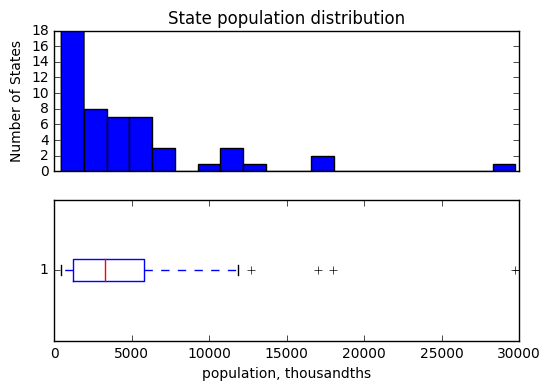

In [28]:
plt.subplot(211)
plt.gca().get_xaxis().set_visible(False)
plt.title('State population distribution')
plt.ylabel('Number of States')
plt.hist(pd_states['pop'], bins=20)
plt.subplot(212)
plt.boxplot(pd_states['pop'], vert=False)
plt.xlabel('population, thousandths')
plt.show()

In [29]:
df_states.orderBy('pop', ascending = True).show(5)

+-----+------+
|state|   pop|
+-----+------+
|   WY|453528|
|   AK|544698|
|   VT|562758|
|   DC|606900|
|   ND|638272|
+-----+------+
only showing top 5 rows



## Example 4. Parquet files

Spark supports various input formats out of the box. One of the popular file formats is Parquet. Parquet is a columnar file format with RLE. Let's compare the performance of csv and parquet files.

We are going to use the popular MovieLens dataset - collected information about movie ratings from visitors.

In [30]:
%%timeit?

In [31]:
%%timeit -n 1 -r 2
spark.read.csv(ml_datasets + '/ratings.csv', header=True, inferSchema=True).count()

1 loop, best of 2: 47.9 s per loop


In [32]:
%%timeit -n 2 -r 1
spark.read.parquet(ml_datasets + '/parquet/ratings').count()

2 loops, best of 1: 592 ms per loop


## Example 5 - Explore MovieLens with DataFrame

In [33]:
df_rating = spark.read.parquet(ml_datasets + '/parquet/ratings')

In [34]:
df_rating.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|    122|   2.0|945544824|
|     1|    172|   1.0|945544871|
|     1|   1221|   5.0|945544788|
|     1|   1441|   4.0|945544871|
|     1|   1609|   3.0|945544824|
+------+-------+------+---------+
only showing top 5 rows



In [35]:
# How many ratings do we have?
df_rating.count()

24404096

In [36]:
# Fields have type
df_rating.schema

StructType(List(StructField(userId,IntegerType,true),StructField(movieId,IntegerType,true),StructField(rating,DoubleType,true),StructField(timestamp,IntegerType,true)))

In [37]:
# I want to know how many movies have rating 3
df_rating_3 = df_rating.filter('rating = 3')

df_rating_3.count()

5011914

In [38]:
# Let's see some of the movies with rating 3

df_movies = spark.read.parquet(ml_datasets + '/parquet/movies')

In [39]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [40]:
df_rating_3.join(df_movies, on='movieId').show(5)

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|   1609|     1|   3.0| 945544824|187 (One Eight Se...|      Drama|Thriller|
|   1961|     1|   3.0| 945544871|     Rain Man (1988)|               Drama|
|   1597|     2|   3.0|1008942773|Conspiracy Theory...|Drama|Mystery|Rom...|
|   1608|     2|   3.0|1008942733|Air Force One (1997)|     Action|Thriller|
|   4963|     2|   3.0|1008942667|Ocean's Eleven (2...|      Crime|Thriller|
+-------+------+------+----------+--------------------+--------------------+
only showing top 5 rows



## Practice II

## Explore SparkSQL

In [41]:
# Load source files into DataFrames
df_movies = spark.read.parquet(ml_datasets + '/parquet/movies')
df_ratings = spark.read.parquet(ml_datasets + '/parquet/ratings')
df_tags = spark.read.parquet(ml_datasets + '/parquet/genome-tags')
df_scores = spark.read.parquet(ml_datasets + '/parquet/genome-scores')


In [42]:
df_movies.createOrReplaceTempView('movies')
df_ratings.createOrReplaceTempView('ratings')
df_tags.createOrReplaceTempView('gtags')
df_scores.createOrReplaceTempView('gscores')

In [43]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [44]:
df_scores.show(5)

+-------+-----+-------------------+
|movieId|tagId|          relevance|
+-------+-----+-------------------+
|      1|    1|0.02400000000000002|
|      1|    2|0.02400000000000002|
|      1|    3|0.05475000000000002|
|      1|    4|0.09200000000000003|
|      1|    5|            0.14825|
+-------+-----+-------------------+
only showing top 5 rows



In [45]:
df_tags.show(5)

+-----+------------+
|tagId|         tag|
+-----+------------+
|    1|         007|
|    2|007 (series)|
|    3|18th century|
|    4|       1920s|
|    5|       1930s|
+-----+------------+
only showing top 5 rows



In [46]:
spark.sql("SELECT * FROM movies WHERE title LIKE 'Shrek%'").show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   4306|        Shrek (2001)|Adventure|Animati...|
|   8360|      Shrek 2 (2004)|Adventure|Animati...|
|  53121|Shrek the Third (...|Adventure|Animati...|
|  64249|Shrek the Halls (...|Adventure|Animati...|
|  78637|Shrek Forever Aft...|Adventure|Animati...|
| 109965|Shrek the Musical...|Children|Comedy|F...|
+-------+--------------------+--------------------+



In [47]:
shrek_tags = spark.sql("SELECT gs.movieId, gs.tagId, gs.relevance, gt.tag FROM gscores gs JOIN gtags gt ON gs.tagId=gt.tagId WHERE movieId=4306")
shrek_tags.show()

+-------+-----+--------------------+---------------+
|movieId|tagId|           relevance|            tag|
+-------+-----+--------------------+---------------+
|   4306|    1| 0.03149999999999997|            007|
|   4306|    2|0.028749999999999998|   007 (series)|
|   4306|    3|0.035999999999999976|   18th century|
|   4306|    4|0.058750000000000024|          1920s|
|   4306|    5| 0.12674999999999997|          1930s|
|   4306|    6| 0.09200000000000003|          1950s|
|   4306|    7| 0.02400000000000002|          1960s|
|   4306|    8|               0.182|          1970s|
|   4306|    9|             0.09025|          1980s|
|   4306|   10| 0.04149999999999998|   19th century|
|   4306|   11|              0.2855|             3d|
|   4306|   12|0.057499999999999996|           70mm|
|   4306|   13| 0.06624999999999998|            80s|
|   4306|   14|0.012749999999999984|           9/11|
|   4306|   15|             0.03075|        aardman|
|   4306|   16|              0.2375|aardman st

In [ ]:
shrek_tags.explain()

In [49]:
shrek_tags.createOrReplaceTempView('shrek_tags')

In [50]:
df_relevant = spark.sql("""
    SELECT gs.movieId,
           m.title,
           gs.tagId,
           gs.relevance,
           t.tag
      FROM gscores gs
      JOIN shrek_tags ss ON ss.tagId=gs.tagId AND ss.movieId=4306
      JOIN movies m ON m.movieId=gs.movieId
      JOIN gtags t ON t.tagId=gs.tagId
    """)

In [51]:
df_relevant.show(10)

+-------+--------------------+-----+--------------------+----+
|movieId|               title|tagId|           relevance| tag|
+-------+--------------------+-----+--------------------+----+
|      1|    Toy Story (1995)|  148| 0.02200000000000002|boat|
|      2|      Jumanji (1995)|  148| 0.02300000000000002|boat|
|      3|Grumpier Old Men ...|  148| 0.09200000000000003|boat|
|      4|Waiting to Exhale...|  148| 0.03149999999999997|boat|
|      5|Father of the Bri...|  148|0.060250000000000026|boat|
|      6|         Heat (1995)|  148| 0.02024999999999999|boat|
|      7|      Sabrina (1995)|  148|0.056999999999999995|boat|
|      8| Tom and Huck (1995)|  148| 0.04325000000000001|boat|
|      9| Sudden Death (1995)|  148|0.020000000000000018|boat|
|     10|    GoldenEye (1995)|  148|             0.09425|boat|
+-------+--------------------+-----+--------------------+----+
only showing top 10 rows



In [52]:
df_relevant_improve = spark.sql("""
    SELECT gs.movieId,
           m.title,
           gs.tagId,
           gs.relevance,
           t.tag,
           ss.relevance AS shrek_relevance
      FROM gscores gs
      JOIN shrek_tags ss ON ss.tagId=gs.tagId AND ss.movieId=4306 AND ss.relevance > 0.8
      JOIN movies m ON m.movieId=gs.movieId
      JOIN gtags t ON t.tagId=gs.tagId
     WHERE gs.relevance > 0.8
    """)

In [53]:
df_relevant_improve.show(10)

+-------+--------------------+-----+------------------+----+---------------+
|movieId|               title|tagId|         relevance| tag|shrek_relevance|
+-------+--------------------+-----+------------------+----+---------------+
|      1|    Toy Story (1995)|  588|           0.97875|kids|         0.9595|
|      2|      Jumanji (1995)|  588|             0.958|kids|         0.9595|
|     54|Big Green, The (1...|  588|           0.93025|kids|         0.9595|
|     56|Kids of the Round...|  588|0.9652499999999999|kids|         0.9595|
|     87|Dunston Checks In...|  588|            0.8225|kids|         0.9595|
|    146|Amazing Panda Adv...|  588|0.8614999999999999|kids|         0.9595|
|    158|       Casper (1995)|  588|0.9312499999999999|kids|         0.9595|
|    239|Goofy Movie, A (1...|  588|0.8402499999999999|kids|         0.9595|
|    250|Heavyweights (Hea...|  588|0.8799999999999999|kids|         0.9595|
|    258|Kid in King Arthu...|  588|           0.84425|kids|         0.9595|

In [54]:
df_relevant_improve.cache().createOrReplaceTempView('relevant')

In [55]:
spark.sql('SELECT AVG(relevance) AS rel, movieId, title FROM relevant GROUP BY movieId, title ORDER BY rel DESC').show(10)

+------------------+-------+--------------------+
|               rel|movieId|               title|
+------------------+-------+--------------------+
|            0.9935|   5419|   Scooby-Doo (2002)|
|           0.98875|   2147|Clan of the Cave ...|
|0.9882500000000001|   3435|Double Indemnity ...|
|0.9877499999999999|  91500|The Hunger Games ...|
|0.9877499999999999|   1178|Paths of Glory (1...|
|             0.986| 118997|Into the Woods (2...|
|           0.98525|  63239|   Cinderella (1997)|
|0.9850000000000001|   4298|Rififi (Du rififi...|
|0.9850000000000001|   1212|Third Man, The (1...|
|           0.98475|   7308|King Solomon's Mi...|
+------------------+-------+--------------------+
only showing top 10 rows



In [56]:
%%time
df_suggested = spark.sql('SELECT AVG(relevance) AS rel, movieId, title FROM relevant WHERE shrek_relevance > 0.9 GROUP BY movieId, title ORDER BY rel DESC')
df_suggested.show(10)

+------------------+-------+--------------------+
|               rel|movieId|               title|
+------------------+-------+--------------------+
|            0.9955|   2720|Inspector Gadget ...|
|0.9944999999999999|    905|It Happened One N...|
|             0.994|   2726| Killing, The (1956)|
|0.9937499999999999|  63540|Beverly Hills Chi...|
|            0.9935|   5419|   Scooby-Doo (2002)|
|           0.99325|   1945|On the Waterfront...|
|          0.992875|  36401|Brothers Grimm, T...|
|           0.99125|   3468| Hustler, The (1961)|
|           0.99075|   1193|One Flew Over the...|
|           0.99075|    923| Citizen Kane (1941)|
+------------------+-------+--------------------+
only showing top 10 rows

CPU times: user 1e+03 µs, sys: 2 ms, total: 3 ms
Wall time: 4.13 s


In [ ]:
df_suggested.explain()

## Explore Catalog

In [58]:
spark.catalog.listDatabases()

[Database(name='default', description='Default Hive database', locationUri='file:/home/cloudera/work/spark-intro/spark-warehouse')]

In [59]:
spark.catalog.listTables()

[Table(name='like_shrek', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gscores', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='gtags', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='movies', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='ratings', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='relevant', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='shrek_tags', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [61]:
# We can materialize our suggestions to a physical table
spark.sql('DROP TABLE IF EXISTS default.like_shrek')
spark.sql('CREATE TABLE default.like_shrek AS SELECT AVG(relevance) AS rel, movieId, title FROM relevant WHERE shrek_relevance > 0.9 GROUP BY movieId, title ')

DataFrame[]

In [62]:
# Now we can see our table is not temporary
spark.catalog.listTables()

[Table(name='like_shrek', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gscores', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='gtags', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='movies', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='ratings', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='relevant', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='shrek_tags', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [63]:
df_like_shrek = spark.sql('SELECT * FROM like_shrek ORDER BY rel DESC')
df_like_shrek.show(10)

+------------------+-------+--------------------+
|               rel|movieid|               title|
+------------------+-------+--------------------+
|            0.9955|   2720|Inspector Gadget ...|
|0.9944999999999999|    905|It Happened One N...|
|             0.994|   2726| Killing, The (1956)|
|0.9937499999999999|  63540|Beverly Hills Chi...|
|            0.9935|   5419|   Scooby-Doo (2002)|
|           0.99325|   1945|On the Waterfront...|
|          0.992875|  36401|Brothers Grimm, T...|
|           0.99125|   3468| Hustler, The (1961)|
|           0.99075|    923| Citizen Kane (1941)|
|           0.99075|   1193|One Flew Over the...|
+------------------+-------+--------------------+
only showing top 10 rows



In [64]:
df_like_shrek.explain()

== Physical Plan ==
*Sort [rel#683 DESC], true, 0
+- Exchange rangepartitioning(rel#683 DESC, 200)
   +- HiveTableScan [rel#683, movieid#684, title#685], MetastoreRelation default, like_shrek


In [ ]:
spark.sql("SELECT * FROM relevant").explain()

## Spark Streaming

The core of Spark Streaming is the DStream (discretized stream) analogous to RDD. 
Spark collects stream data in microbatches, creating multiple RDDs. Each batch, a new DStream is produced, containing all the RDDs collected during the batch.

## Example: Real-time Word Popularity


Let's start a netcat server. The server will listen on port 9999 and will send a line from the standard input each second (`-i 1` option).

```bash
$ nc -l -p 9999 -i 1 < data/book-allice-wonderland.txt
```

**wordcount-streaming.py**

```python
import sys
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import re

if __name__ == "__main__":

    hostname = "localhost"
    port = 9999
    
    sc = SparkContext(appName="StreamingWordCountInPython")
    
    # Necessary log4j logging level settings are done 
    log4j = sc._jvm.org.apache.log4j
    log4j.LogManager.getRootLogger().setLevel(log4j.Level.ERROR)
    
    ssc = StreamingContext(sc, 2)
    lines_ds = ssc.socketTextStream(hostname, port)
    words = lines_ds.flatMap(lambda line: re.sub('\W', ' ', line).split() )
    counts_sorted = words.countByValue()    \
              .transform(lambda rdd: rdd.sortBy(lambda x: x[1], False))
    counts_sorted.pprint()

    
    ssc.start()
    ssc.awaitTermination()
```


```bash
$ spark-submit --master=local[*] wordcount-streaming.py
```



## Window Processing

- *Batch Interval* - The time interval at which a new DStream is produced. E.g. each 10 seconds
- *Window Length* - The duration of batch intervals over which the operation is performed. E.g. messages last 5  minutes
- *Slide Interval* - The interval at which the window operation is performed. E.g. every 20 seconds

- *Block Interval*  - The duration of a micro-batch. Default is 200ms

## Example - Online Word Popularity

What if we want to monitor how the popularity of a word changes over time?
We want to see what where the most popular words in the past 5 minutes.


**wordcount-window.py**

```python
import sys
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import re

if __name__ == "__main__":

    sc = SparkContext(appName="PythonStreamingWordCount")
    
    # Necessary log4j logging level settings are done 
    log4j = sc._jvm.org.apache.log4j
    log4j.LogManager.getRootLogger().setLevel(log4j.Level.ERROR)
    
    # Create the Spark Streaming Context with 10 seconds batch interval
    ssc = StreamingContext(sc, 10)
    
    # Set the check point directory for saving the data to recover when there is a crash
    ssc.checkpoint("checkpoint")
    
    # Create a DStream that connects to localhost on port 9999
    lines_ds = ssc.socketTextStream("localhost", 9999)
    words = lines_ds.flatMap(lambda line: re.sub('\W', ' ', line).split() )
    counts_sorted = words.countByValueAndWindow(300,10)   \
                   .transform(lambda rdd: rdd.sortBy(lambda x: x[1], False))
    counts_sorted.pprint()

    ssc.start()
    ssc.awaitTermination()

```